# Forecasting crime in NYC

In [20]:
# le classique imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.animation
from sklearn.metrics import mean_absolute_error
import geoplot
import geopandas
from shapely.geometry import Point, Polygon
import geoplot.crs as gcrs

path = 'C:/Users/Zaca/Documents/Datasets/nyc/'
path_to_functions = 'C:/Users/Zaca/Documents/GitHub/useful-functions/'

sys.path.append(path_to_functions)

from plotting import default_plot, make_hcolorbar

# Plotting functions

In [2]:
def arima_plot(predicted, observed, save=False):
   
    # ARIMA plot function
    fig, ax = plt.subplots(figsize=(6, 4))
    ax = default_plot(ax, ['left', 'bottom'])
    plt.xticks([6, 18], ['2017', '2018'])
    plt.vlines(12, 6500, 9500, ls='dashed',color='grey')
    plt.ylim(6500, 9500)
    plt.xlim(0, 24)
    plt.ylabel('Crimes per month')
    plt.plot(test, lw=3, color='k', label='Observed')
    plt.plot(predictions, color='r', lw=3, label='Predicted')
    plt.tight_layout()
    plt.legend(frameon=False, bbox_to_anchor=(1, 1.1))
    
    if save:
        plt.savefig('figures/nyc_ARIMA.png')
      

def choropleth(basemap, save=False):
    
    # plot the map
    ax = geoplot.choropleth(basemap, hue='rates', figsize=(12, 12), lw= 1, edgecolor='k', alpha=1, cmap='plasma', projection=gcrs.AlbersEqualArea())
    
    # save figure if requested
    if save:
        plt.savefig('figures/arimap.png', dpi=300)

# matplotlib params

In [3]:
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"   
mpl.rcParams['font.size'] = 13
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5   

# Algorithm functions

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    
    # calculate mean absolute error in percentage of total
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def into_timeseries(df):
    
    # transform crime dataframe ii timeseries
    df = df.groupby('date').agg(count=('precinct','count')).reset_index()
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index)
    return df

def get_stationarity(timeseries, window=12):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    
    decomposition = seasonal_decompose(timeseries, model='additive')
    decomposition.plot();
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['count'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

def auto_correlation(timeseries):
    plot_pacf(timeseries.diff().dropna(), lags=20, title='Partial Autocorrelation')
    plot_acf(timeseries.diff().dropna(), title="1st Order Differencing")
        

def micro_arima(precinct):

    precinct_data = crime_subset.loc[(crime_subset.precinct == precinct)]

    precinct_ts = into_timeseries(precinct_data)
    precinct_ts = precinct_ts.resample('MS').sum()

    train = precinct_ts['2007-01-01':'2016-12-01'].values
    test = precinct_ts['2017-01-01':].values

    history = [x for x in train]
    predictions = []
    error = []

    for t in tqdm(range(len(test))):
        model = ARIMA(history, order=(2,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions += [yhat]
        obs = test[t]
        history += [obs]
        error += [abs(yhat - obs)]

    mae = mean_absolute_error(test, predictions)
    print('Test MAE: ' + str(mae) + ' (' + str(precinct) + ')')

    data = {'precinct': [precinct]*len(test), 
            'prediction': [x[0] for x in predictions], 
            'observed': [x[0] for x in test], 
            'date':precinct_ts['2017-01-01':].index,
            'mae':[x[0] for x in error]}

    output = pd.DataFrame(data)
    
    return output

# Read pre-processed data
- Opening the data file generated by the nyc-crime-data-cleaning notebook.

In [5]:
# opening dataset
crime = pd.read_csv(path + 'nypd_historic_07-18.csv', index_col=0)

C:\Users\Zaca\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Filter by crimes
- In order to save memory I will only use a subset of the crimes reported in the dataset

In [6]:
violent = ['FELONY ASSAULT', 'ROBBERY', 'RAPE']
propert = ['BURGLARY', 'ARSON', 'GRAND LARCENY', 'GRAND LARCENY OF MOTOR VEHICLE']
crime_filter = violent + propert
crime_subset = crime[crime.description.isin(crime_filter)]

# Transform to timeseries

In [7]:
crime_ts = into_timeseries(crime_subset)

# Monthly forecasting

In [8]:
# group data into sum of every crime in a month
monthly = crime_ts.resample('MS').sum()

# Analyze stationarity

ADF Statistic: -1.4226913464609443
p-value: 0.5713505625009688
Critical Values:
	1%: -3.482087964046026
	5%: -2.8842185101614626
	10%: -2.578864381347275


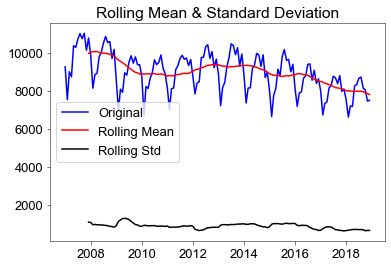

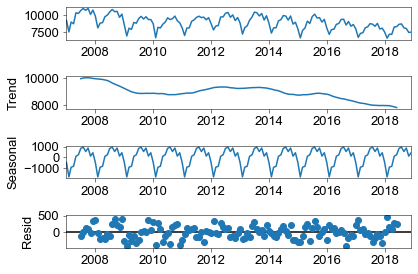

In [9]:
get_stationarity(monthly)

- there is a strong seasonal component which is good!
- there is also significant trend we might be interested in removing it. 

# Calculate autocorrelations to determine parameters of ARIMA

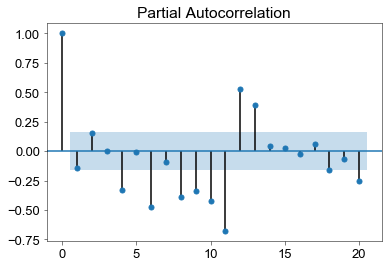

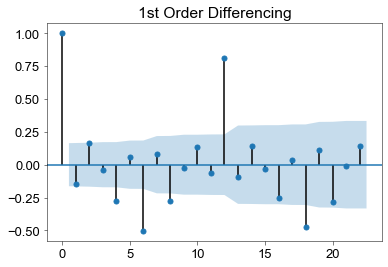

In [10]:
auto_correlation(monthly)

# Create ARIMA model

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.count   No. Observations:                  143
Model:                 ARIMA(8, 1, 1)   Log Likelihood               -1090.418
Method:                       css-mle   S.D. of innovations            485.604
Date:                Wed, 25 Mar 2020   AIC                           2202.836
Time:                        11:33:34   BIC                           2235.427
Sample:                    02-01-2007   HQIC                          2216.080
                         - 12-01-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -15.8387      6.793     -2.332      0.020     -29.153      -2.524
ar.L1.D.count     0.2742      0.086      3.187      0.001       0.106       0.443
ar.L2.D.count    -0.1565      0.081     -1.924      0.054      -0.316       0.003
ar.L3.D.count    -0.0870      0.070     -1.245      0.213      -0.224       0.050
ar.L4.D.count    -0.3512      0.071     -4.940      0.000      -0.491      -0.212
ar.L5.D.count     0.0424      0.070      0.602      0.547      -0.096       0.180
ar.L6.D.count    -0.4784      0.069     -6.942      0.000      -0.613      -0.343
ar.L7.D.count     0.1034      0.082      1.255      0.209      -0.058       0.265
ar.L8.D.count    -0.4665      0.078     -5.946      0.000      -0.620      -0.313
ma.L1.D.count    -0.6594      0.064    -10.356      0.000      -0.784      -0.535
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9063           -0.5148j            1.0423           -0.4178
AR.2           -0.9063           +0.5148j            1.0423            0.4178
AR.3            0.8804           -0.5066j            1.0158           -0.0831
AR.4            0.8804           +0.5066j            1.0158            0.0831
AR.5            0.4784           -1.0537j            1.1572           -0.1822
AR.6            0.4784           +1.0537j            1.1572            0.1822
AR.7           -0.3416           -1.1451j            1.1950           -0.2961
AR.8           -0.3416           +1.1451j            1.1950            0.2961
MA.1            1.5166           +0.0000j            1.5166            0.0000
-----------------------------------------------------------------------------
"""

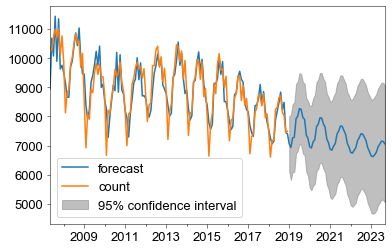

In [11]:
model = ARIMA(monthly, order=(8,1,1))
results = model.fit(disp=0)
results.plot_predict(4,200);
results.summary()

# Testing ARIMA model on 2017-2018 after training 2007-2016

In [12]:
# Split into train and test
train = monthly['2007-01-01':'2016-12-01'].values
test = monthly['2017-01-01':].values

# create history to keep updating the model
history = [x for x in train]

# save predictions
predictions = []

for t in tqdm(range(len(test))):
    model = ARIMA(history, order=(8,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

100%|██████████| 24/24 [00:48<00:00,  2.02s/it]


# Calculating mean absolute error

In [13]:
error = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % error)

Test MAE: 224.719


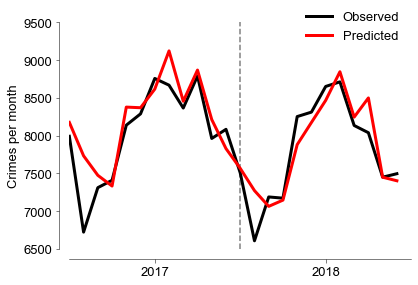

In [14]:
# make ARIMA plot
arima_plot(predictions, test, save=False)

# Apply ARIMA function to each precinct.

In [15]:
precinct_arimas = [micro_arima(x) for x in list(crime_subset.precinct.unique())]

  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 11.38219505477344 (102)


  8%|▊         | 2/24 [00:00<00:01, 18.07it/s]

Test MAE: 14.87135998791617 (52)


  8%|▊         | 2/24 [00:00<00:01, 19.63it/s]

Test MAE: 10.78098737261031 (23)


  8%|▊         | 2/24 [00:00<00:01, 19.55it/s]

Test MAE: 20.63867537497502 (40)


  8%|▊         | 2/24 [00:00<00:01, 16.74it/s]

Test MAE: 17.45955612908242 (47)


  8%|▊         | 2/24 [00:00<00:01, 17.55it/s]

Test MAE: 12.249172246639253 (60)


  8%|▊         | 2/24 [00:00<00:01, 17.66it/s]

Test MAE: 11.988940919352865 (103)


  8%|▊         | 2/24 [00:00<00:01, 18.71it/s]

Test MAE: 13.313916681599247 (46)


  4%|▍         | 1/24 [00:00<00:02,  8.81it/s]

Test MAE: 15.70928444680115 (105)


 12%|█▎        | 3/24 [00:00<00:00, 24.69it/s]

Test MAE: 5.43637012782348 (122)


  8%|▊         | 2/24 [00:00<00:01, 15.11it/s]

Test MAE: 10.758423775373705 (68)


  8%|▊         | 2/24 [00:00<00:01, 19.38it/s]

Test MAE: 11.24410126535282 (77)


  8%|▊         | 2/24 [00:00<00:01, 18.88it/s]

Test MAE: 14.68146626619666 (79)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 12.303237186651907 (32)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 12.823538869692769 (45)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 9.167524847002982 (120)


  8%|▊         | 2/24 [00:00<00:01, 19.63it/s]

Test MAE: 10.52608089762578 (81)


  8%|▊         | 2/24 [00:00<00:01, 16.19it/s]

Test MAE: 11.861568727227853 (113)


  8%|▊         | 2/24 [00:00<00:01, 17.75it/s]

Test MAE: 19.24755199557818 (44)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 11.392248258707781 (107)


  8%|▊         | 2/24 [00:00<00:01, 17.59it/s]

Test MAE: 8.726640987870523 (34)


  8%|▊         | 2/24 [00:00<00:01, 17.57it/s]

Test MAE: 13.081678528531768 (67)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 10.570572864112195 (9)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 9.14531646516694 (69)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 22.637835296693293 (18)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 21.0634933871408 (43)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 12.366244736495133 (41)


  8%|▊         | 2/24 [00:00<00:01, 18.95it/s]

Test MAE: 9.2002027495338 (61)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 10.432634573545068 (78)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 24.931573732416638 (75)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 13.703344061502671 (6)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 9.575450211133813 (24)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 11.477082915945607 (63)


  8%|▊         | 2/24 [00:00<00:01, 16.68it/s]

Test MAE: 15.030909180134799 (25)


  8%|▊         | 2/24 [00:00<00:01, 14.40it/s]

Test MAE: 10.059649570630157 (66)


  8%|▊         | 2/24 [00:00<00:01, 19.30it/s]

Test MAE: 19.260941471716528 (19)


 88%|████████▊ | 21/24 [00:01<00:00, 12.25it/s]C:\Users\Zaca\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 13.514296375304633 (48)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 13.423849302002717 (90)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 15.18667069219129 (73)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 12.054343801373719 (62)


 21%|██        | 5/24 [00:00<00:02,  8.42it/s]C:\Users\Zaca\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
  8%|▊         | 2/24 [00:00<00:01, 13.14it/s]

Test MAE: 14.561180041976627 (42)


  8%|▊         | 2/24 [00:00<00:01, 15.52it/s]

Test MAE: 19.08109069460404 (110)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 15.62468437876223 (49)


  8%|▊         | 2/24 [00:00<00:01, 18.07it/s]

Test MAE: 15.72810938398623 (70)


  8%|▊         | 2/24 [00:00<00:01, 19.91it/s]

Test MAE: 12.654182620426292 (71)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 8.609355976553843 (17)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 11.623911384720307 (106)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 13.3981163752377 (84)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 23.36283030949019 (14)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 8.372995472756566 (100)


  8%|▊         | 2/24 [00:00<00:01, 17.45it/s]

Test MAE: 11.360782199761838 (28)


  8%|▊         | 2/24 [00:00<00:01, 14.61it/s]

Test MAE: 14.073860702182046 (115)


 12%|█▎        | 3/24 [00:00<00:00, 21.20it/s]

Test MAE: 12.030948645621601 (33)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 10.694853677760653 (30)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 9.136411763368493 (88)


  8%|▊         | 2/24 [00:00<00:01, 18.29it/s]

Test MAE: 12.79721227189395 (104)


 12%|█▎        | 3/24 [00:00<00:00, 24.00it/s]

Test MAE: 13.111392824813683 (83)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 11.722805193097509 (72)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 15.19537856142306 (1)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 15.451806711868706 (13)


 12%|█▎        | 3/24 [00:00<00:00, 24.00it/s]

Test MAE: 8.976286808566003 (5)


  8%|▊         | 2/24 [00:00<00:01, 18.68it/s]

Test MAE: 8.013828397718024 (26)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 8.76992400560542 (50)


 12%|█▎        | 3/24 [00:00<00:00, 24.00it/s]

Test MAE: 16.534574222123933 (109)


  8%|▊         | 2/24 [00:00<00:01, 19.74it/s]

Test MAE: 7.127065674622024 (7)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 6.267155103165656 (76)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 12.153666140537647 (101)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 9.315013599148939 (10)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 11.492947725573382 (108)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 6.12580264198256 (123)


  4%|▍         | 1/24 [00:00<00:02,  8.63it/s]

Test MAE: 15.616295191105053 (114)


  8%|▊         | 2/24 [00:00<00:01, 19.29it/s]

Test MAE: 10.878296871373076 (111)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 9.568297298250958 (20)


 12%|█▎        | 3/24 [00:00<00:00, 22.77it/s]

Test MAE: 11.644770070353578 (94)


  0%|          | 0/24 [00:00<?, ?it/s]

Test MAE: 3.2815240998748547 (22)


  8%|▊         | 2/24 [00:00<00:01, 13.43it/s]

Test MAE: 10.327240436766287 (112)


100%|██████████| 24/24 [00:01<00:00, 16.21it/s]

Test MAE: 11.254152399776236 (121)


In [16]:
# concatenate output dataframes
output = pd.concat(precinct_arimas)

In [17]:
# save to file
output.to_csv('processed_csv/arima_results.csv')

# Creating the map plot

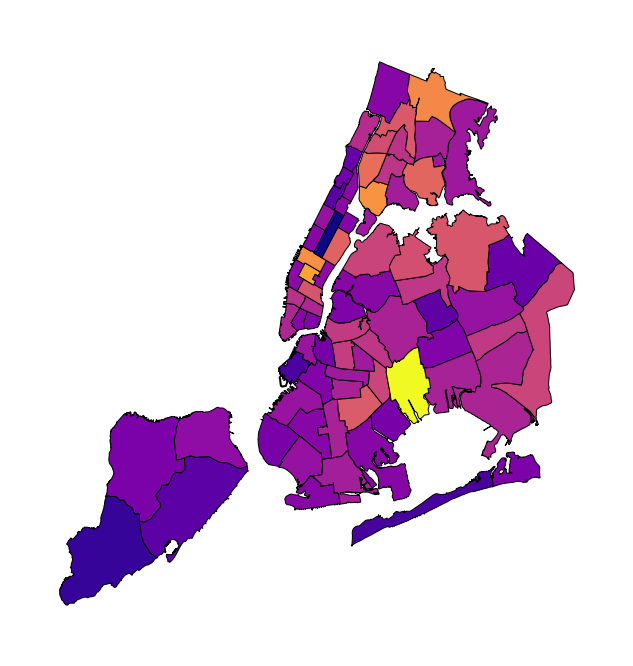

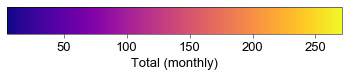

In [21]:
# open arima results
arima = pd.read_csv('processed_csv/arima_results.csv', index_col=0)

# calculate mean crimes forecasts
rates = arima.groupby('precinct').agg(rates=('prediction','mean'))
rates.sort_values(by='rates', ascending=False, inplace=True)

# open shapefile
pcints = geopandas.read_file(path + 'nypd_precincts.shp').to_crs(epsg=4326)

# clean a variable dtypes
pcints['pct'] = pcints['pct'].astype('int32')

# create a new, clean GeoDataFrame
clean_map = geopandas.GeoDataFrame()
clean_map['precinct'] = pcints['pct'].unique()
clean_map['geometry'] = [Polygon(max(pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union, key=lambda a: a.area).exterior) if pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union.geom_type == 'MultiPolygon' else Polygon(pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union.exterior) for pct in clean_map.precinct]

# merge ARIMA results into the map data
clean_map = clean_map.merge(rates, on='precinct')

# plot map
choropleth(clean_map, save=False)

# plot colorbar
make_hcolorbar(clean_map['rates'], 'Total (monthly)', mpl.cm.get_cmap('plasma'), 'figures/precinct_heatmap_colorbar.png')